# Model 3 - CNN+RNN using both geo-spatial and kinematic features

In [12]:
%load_ext autoreload
%autoreload 2

import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

sys.path.append('./src')
from data_utils import *
clear_output(wait=False)

### Load train, validation and test data

In [13]:
user_train, user_val, user_test = train, val, test = train_test_data_split()

In [14]:
data_train = pd.concat([create_data_frame(*load_user_data(user), segmentation=True) for user in user_train]).reset_index(drop=True)
data_val = pd.concat([create_data_frame(*load_user_data(user), segmentation=True) for user in user_val]).reset_index(drop=True)
data_test = pd.concat([create_data_frame(*load_user_data(user), segmentation=True) for user in user_test]).reset_index(drop=True)

### Load precomputed image frames

In [15]:
image_data = {}
for user_id in user_train + user_val + user_test:
    with open(f'/mnt/array/valse_data/DeepLearning/Project/Pickle/images_list_{user_id}.pickle', 'rb') as f:
        image_data[user_id] = np.stack(pickle.load(f), axis = 0).astype(float)

#### Define Image Tensor Dataset

We implement our own Tensor Dataset in order to be able to do fast lookup of sequences and images.

In [16]:
class ImageTensorDataset(torch.utils.data.Dataset):

    def __init__(self, df, image_data):
        self.seq = np.stack([np.roll(df[['delta_d', 'bearing']].values, i, axis = 0) for i in range(5, -1, -1)], axis = 1)
        self.seq = self.seq[df['segment_ix'] >= 5]
        
        self.labels = df[df['segment_ix'] >= 5]['label'].values
        self.tod = df[df['segment_ix'] >= 5]['tod'].values
        self.user_id = df[df['segment_ix'] >= 5]['user'].values
        self.image_ix = df[df['segment_ix'] >= 5]['image_ix'].values        
        self.image_data = image_data
        self.tod_one_hot = np.eye(5)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, key):
        image = self.image_data[self.user_id[key]][self.image_ix[key]]
        tod_one_hot = self.tod_one_hot[self.tod[key]]
        return image, tod_one_hot, self.labels[key]   

## Example Input/output data from ``TensorDataset``

In [27]:
demo_dataset = ImageTensorDataset(data_train.head(3), image_data)

for X_img, X_tod, y in torch.utils.data.DataLoader(demo_dataset, batch_size=3, shuffle=True):
    print('X_img :', X_img.shape)
    print(X_img[0, :, :, 0])
    print('X_tod :', X_tod.shape)
    print(X_tod[0])
    print('y :', y.shape)
    print(y[0])

X_img : torch.Size([3, 9, 9, 11])
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=torch.float64)
X_tod : torch.Size([3, 6])
tensor([0., 0., 0., 1., 0., 0.], dtype=torch.float64)
y : torch.Size([3])
tensor(0)


### Hyper Parameters

In [43]:
IMG_INPUT_H_W = 9, 9
IMG_INPUT_C = 11
TOD_INPUT_DIM = 6
CNN_HIDDEN_DIM = 32
CNN_HIDDEN_DIM_2 = 16
CNN_KERNEL_SIZE = 3
CNN_PADDING = 1
FC_HIDDEN_DIM = 16
NUM_CLASSES = 2

DROPOUT_PROP = .2

NUM_EPOCH = 25
BATCH_SIZE = 12000
LEARNING_RATE = 0.1
LEARNING_DECAY_FACTOR = 0.1
LEARNING_DECAY_EPOCHS = [15,20]

#### Define Data Loaders

In [44]:
train_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_train, image_data), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_val, image_data), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_test, image_data), batch_size=BATCH_SIZE, shuffle=True)

#### Define some utility functions for building and running the network

In [45]:
def adjust_lr(optimizer, epoch):
    number_decay_points_passed = np.sum(epoch >= np.array(LEARNING_DECAY_EPOCHS))
    lr = LEARNING_RATE * (LEARNING_DECAY_FACTOR ** number_decay_points_passed)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def conv2d_output_shape(h_w, kernel_size=1, stride=1, padding=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * padding) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * padding) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

### Define network for Convolutional neural network (CNN) using only geo-spatial features

In [46]:
class CnnNet(nn.Module):

    def __init__(self):
        super(CnnNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(IMG_INPUT_C, CNN_HIDDEN_DIM, kernel_size=CNN_KERNEL_SIZE, padding=CNN_PADDING),
            nn.BatchNorm2d(CNN_HIDDEN_DIM),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(DROPOUT_PROP)
        )
        
        h, w = IMG_INPUT_H_W
        #print(h, w)
        h, w = conv2d_output_shape((h, w), CNN_KERNEL_SIZE, padding=CNN_PADDING)
        #print(h, w)
        h, w = conv2d_output_shape((h, w), kernel_size=3, stride=2, padding=0)        
        #print(h, w)
        self.layer2 = nn.Sequential(
            nn.Conv2d(CNN_HIDDEN_DIM, CNN_HIDDEN_DIM_2, kernel_size=CNN_KERNEL_SIZE, padding=CNN_PADDING),
            nn.BatchNorm2d(CNN_HIDDEN_DIM_2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(DROPOUT_PROP)
        )
        
        h, w = conv2d_output_shape((h, w), CNN_KERNEL_SIZE, padding=CNN_PADDING)
        #print(h, w)
        h, w = conv2d_output_shape((h, w), kernel_size=2, stride=2, padding=0)
        #print(h, w)
        
        self.fc1 = nn.Linear(CNN_HIDDEN_DIM_2 * h * w + TOD_INPUT_DIM, FC_HIDDEN_DIM)
        self.fc2 = nn.Linear(FC_HIDDEN_DIM, NUM_CLASSES)        

    def forward(self, X_img, X_tod):
        X_img = X_img.permute(0, 3, 1, 2)
        out = self.layer1(X_img)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        #print(X_tod.shape)
        out = torch.cat([out, X_tod], dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = F.softmax(out, dim=1)
        return out

#### Define class weights due to large class im-balance

In [47]:
class_weights = [(data_train['label'] == 0).sum()/(data_train['label'] == x).sum() for x in range(NUM_CLASSES)]
class_weights

[1.0, 0.3686257150152608]

#### Define model, optimizer and loss

In [48]:
device = torch.device('cuda:1') # PyTorch v0.4.0
model = CnnNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-10)
criterion = nn.CrossEntropyLoss(weight = torch.Tensor(class_weights).to(device))

#### Number of parameters

In [49]:
np.sum([np.product(x.cpu().detach().numpy().shape) for x in model.parameters()])

9090

#### Test input/output of model

In [50]:
out = model(X_img.to(device, dtype=torch.float), X_tod.to(device, dtype=torch.float))
print(out.shape)

torch.Size([306, 2])


In [51]:
out[:2].cpu()

tensor([[0.6037, 0.3963],
        [0.5984, 0.4016]], grad_fn=<CopyBackwards>)

In [52]:
phases = {
    'train': {
        'dataloader': train_dataloader,
        'is_training': True,
    },
    'validation': {
        'dataloader': val_dataloader,
        'is_training': False,
    },
    'test': {
        'dataloader': test_dataloader,
        'is_training': False,
    }
}

### Train / Validation loop

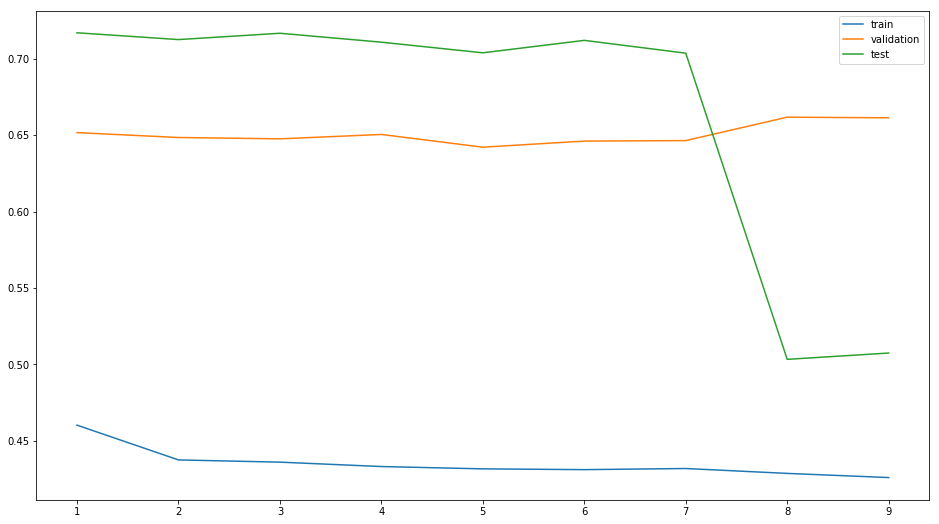

In [ ]:
for epoch in range(1, NUM_EPOCH + 1):
    
    for phase_name, phase in phases.items():
        epoach_loss = 0.0
                
        phase_is_training = phase['is_training']
        phase_dataloader = phase['dataloader']
        model.train(phase_is_training)
        
        # Ajust and save the learning rate in the phase dict
        if phase_is_training:
            lr = adjust_lr(optimizer, epoch)
            phase.setdefault('lr', []).append(lr)
            
        # Iterate over each bath in the phase
        for i, batch in enumerate(phase_dataloader, 1):
            #print(i)
            X_seq, X_tod, y = batch
            

            X_seq = X_seq.to(device, dtype=torch.float)
            X_tod = X_tod.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.int64)

            with torch.set_grad_enabled(phase_is_training):
                out = model(X_seq, X_tod)
                loss = criterion(out, y)

            if phase_is_training:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(model.parameters(), 0.5)
                optimizer.step()
        
            epoach_loss += loss.item()
        
        # Save the loss for the epoch in the phase dict
        phase.setdefault('loss', []).append(epoach_loss/i)
        
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize = (16, 9))
    #ax.set_yscale('log')
    
    for phase_name, phase in phases.items():
        ax.plot(np.arange(1, epoch + 1), phase['loss'], label = phase_name)        
    
    ax.legend()
    plt.show();            

### Validation/Test prediction loop

In [ ]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    phase_dataloader = phase['dataloader']
    phase['predicted'] = []
    phase['true'] = []
    
    for i, batch in enumerate(phase_dataloader, 1):
        X_img, X_tod, y = batch

        phase['true'].extend(list(y.numpy()))
        
        X_img = X_img.to(device, dtype=torch.float)
        X_tod = X_tod.to(device, dtype=torch.float)
        y = y.to(device, dtype=torch.float)
        
        with torch.no_grad():
            out = model(X_img, X_tod)
            probability, predicted = torch.max(out, 1)
            
        phase['predicted'].extend(list(predicted.cpu().numpy()))        

### Final results

In [ ]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    print(phase_name)
    print(classification_report(phase['true'], phase['predicted'], target_names = ['Motion','Stop']))